# H-He Mixture

In this notebook we will calculate the diffusion and interdiffusion coefficients of Binary Ionic Mixture (BIM) of Hydrogen and Helium. This notebook tries to reproduce the data obtained from Hansen, Joly, and McDonald's [paper](https://doi.org/10.1016/0378-4371(85)90022-6).

The YAML input file can be found at [input_file](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/examples/BIM/input_files/BIM_cgs.yaml) and this notebook at [notebook](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/examples/BIM/H-He_Mixture.ipynb).

In [1]:
# Import the usual libraries
%pylab
%matplotlib inline
import os
plt.style.use('MSUstyle')
# Import sarkas
from sarkas.processes import Simulation, PostProcess


# Create the file path to the YAML input file
input_file_name = os.path.join('input_files', 'BIM_cgs.yaml')

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Simulation

In [2]:
# sim = Simulation(input_file_name)
# sim.setup(read_yaml=True)
# sim.run()

## PostProcessing


In [3]:
postproc = PostProcess(input_file_name)
postproc.setup(read_yaml=True)

### Thermodynamic Check

Let's make sure that the equilibration phase was $NVT$ and the production phase $NVE$.

In [4]:
# Equilibration check
postproc.therm.setup(postproc.parameters)
# postproc.therm.temp_energy_plot(postproc, phase='equilibration')


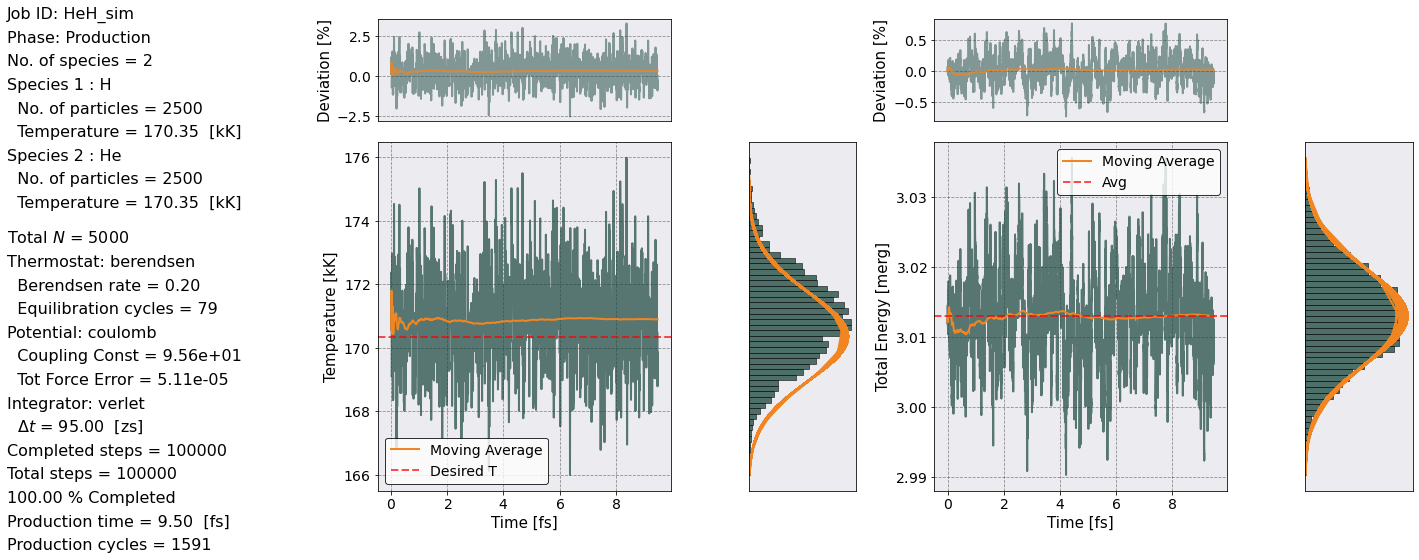

In [5]:
# Production check
postproc.therm.temp_energy_plot(postproc, phase='production')

### Pair Distribution Function

Let's look at $g_{\alpha \beta}(r)$. Just for fun.

<AxesSubplot:xlabel='$r / a_{\\rm ws}$'>

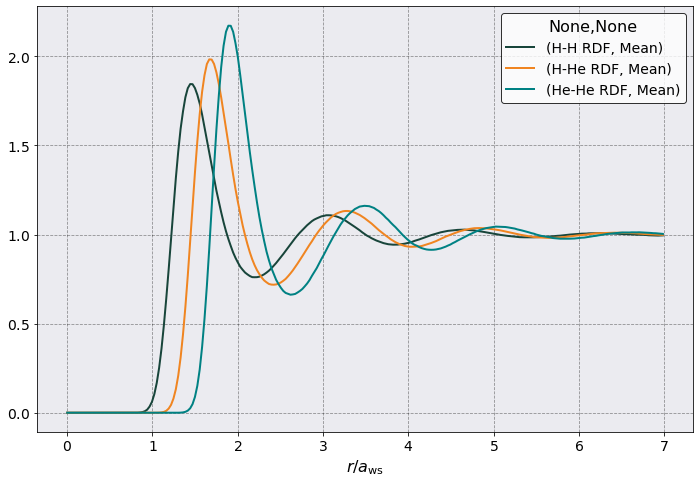

In [6]:
postproc.rdf.setup(postproc.parameters)
postproc.rdf.parse()
postproc.rdf.plot(scaling = postproc.parameters.a_ws, 
                  y = [("H-H RDF", "Mean"),
                      ("H-He RDF", "Mean"),
                      ("He-He RDF", "Mean")],
                  xlabel = r'$r / a_{\rm ws}$')

### Static Structure Function

Let's calculate $S_{\alpha\beta}(k)$ up to $ka = 5$ and angle average it.

In [7]:
from sarkas.tools.observables import StaticStructureFactor

ssf = StaticStructureFactor()
ssf.no_slices = 4
ssf.angle_averaging = 'full'
ssf.max_ka_value = 5
ssf.setup(postproc.parameters)
ssf.pretty_print()




===================== Static Structure Function ====================== 

k wavevector information saved in: 
 Simulations/HeH_sim/PostProcessing/k_space_data/k_arrays.npz
n(k,t) Data saved in: 
 Simulations/HeH_sim/PostProcessing/k_space_data/nkt.h5
Data saved in: 
 Simulations/HeH_sim/PostProcessing/StaticStructureFunction/Production/StaticStructureFunction_HeH_sim.h5
Data accessible at: self.k_list, self.k_counts, self.ka_values, self.dataframe

Smallest wavevector k_min = 2 pi / L = 3.9 / N^(1/3)
k_min = 0.2279 / a_ws = 9.2974e+08 [1/cm]

Angle averaging choice: full
	Maximum angle averaged k harmonics = n_x, n_y, n_z = 12, 12, 12
	Largest angle averaged k_max = k_min * sqrt( n_x^2 + n_y^2 + n_z^2)
	k_max = 4.7377 / a_ws = 1.9324e+10 [1/cm]

Total number of k values to calculate = 2196
No. of unique ka values to calculate = 354


In [8]:
ssf.parse()
ssf.dataframe

Inverse Wavelength   H-H SSF            H-He SSF           He-He SSF  \
                   NaN      Mean       Std      Mean       Std      Mean   
0         9.297400e+08  0.602529  0.602529 -0.301900 -0.301900  0.151476   
1         1.314851e+09  0.950866  0.950866 -0.477511 -0.477511  0.240235   
2         1.610357e+09  0.739990  0.739990 -0.372485 -0.372485  0.188129   
3         1.859480e+09  0.752397  0.752397 -0.379395 -0.379395  0.192214   
4         2.078962e+09  1.002572  1.002572 -0.506872 -0.506872  0.257413   
..                 ...       ...       ...       ...       ...       ...   
349       1.785972e+10  1.192680  1.192680  0.436384  0.436384  1.359468   
350       1.826649e+10  1.237796  1.237796  0.405055  0.405055  1.127594   
351       1.831376e+10  1.351196  1.351196  0.469020  0.469020  1.221888   
352       1.880283e+10  1.242406  1.242406  0.364108  0.364108  1.086201   
353       1.932428e+10  1.315648  1.315648  0.305602  0.305602  0.940871   

               
          Std  
0    0.151476  
1    0.240235  
2    0.188129  
3    0.192214  
4    0.257413  
..        ...  
349  1.359468  
350  1.127594  
351  1.221888  
352  1.086201  
353  0.940871  

[354 rows x 7 columns]

<AxesSubplot:xlabel='$ka$'>

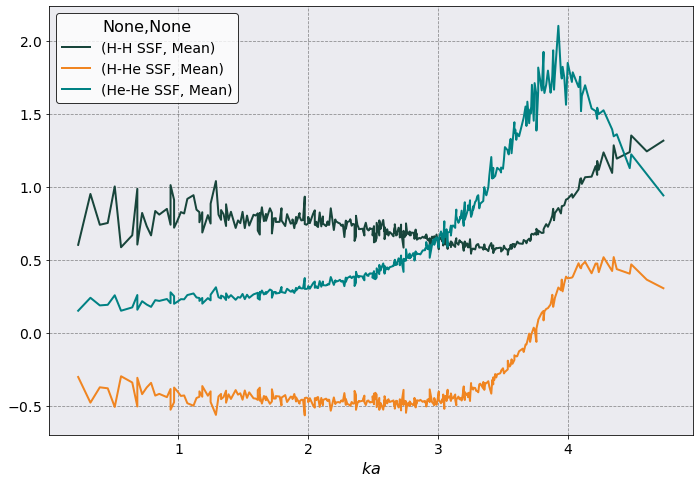

In [9]:
ssf.plot(
    scaling = 1 /ssf.a_ws,
    y= [('H-H SSF', 'Mean'), ('H-He SSF', 'Mean'), ('He-He SSF', 'Mean')], 
    xlabel = r'$ka$')

## Interdiffusion

The interdiffusion coefficient is calculated by the Green-Kubo relation 

$$ D_{12} = \frac{\mathcal{J}}{3Nx_1x_2} \int_0^\infty dt {\rm{{ACF}_{ID}}} = \frac{\mathcal{J}}{3Nx_1x_2} \int_0^\infty dt \langle \mathbf{j}(0) \cdot \mathbf{j}(t) \rangle, $$

where $\mathcal{J}$ is the thermodynamic factor

$$ \mathcal{J} = \frac{x_1x_2}{S_{cc}(k = 0)} $$

and $S_{cc}(k)$ is the concentration-concentration structure factor that can be decomposed into partial structure factors as

$$ S_{cc}(k) = x_1x_2[x_2S_{11}(k) + x_1S_{22}(k) - 2\sqrt{x_1x_2}S_{12}(k)]. $$

Calculating the interdiffusion coefficient $D_{12}$ is two-fold in that we must compute the auto-correlation function $\rm{{ACF}_{ID}}$ and the thermodynamic factor $\mathcal J$.

We will calculate $\mathcal J$ first by fitting the following function to $S_{\alpha\beta}(k)$

In [10]:
# Define fitting functions
from scipy.optimize import curve_fit

def poly_fit(x, a, b, c):
    return a*x**2 + b*x + c

def lin_fit(x, a, b):
    return a*x + b

def inv_fit(x, a, b, c):
    return a*np.exp(b*x) + c

As you can see from above $S_{\alpha\beta}(k)$ are pretty noisy. Therefore we choose only those $ka$ values for which we have averaged more than three $S_{\alpha\beta}(k)$.

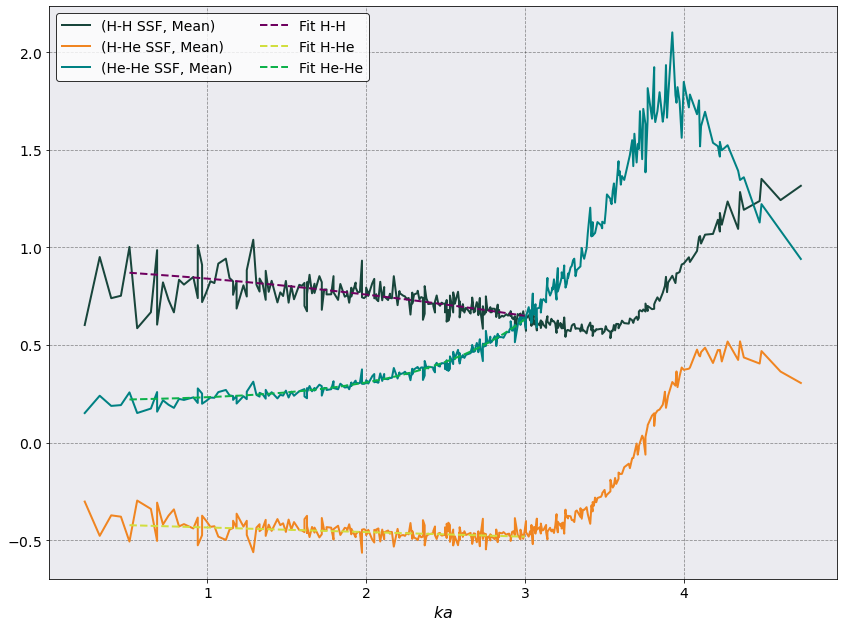

In [11]:
# Create masks
mask = ssf.k_counts > 3
ka_values_full = ssf.ka_values[mask]

ka_mask = ka_values_full < 3.0
ka_values = ka_values_full[ka_mask]

# Remake the plot        
fig, ax = plt.subplots(1,1, figsize = (12,9))
ssf.plot(
    scaling = 1 /ssf.a_ws,
    y= [('H-H SSF', 'Mean'), ('H-He SSF', 'Mean'), ('He-He SSF', 'Mean')], 
    xlabel = r'$ka$', ax = ax)

# H-H Fit and plot
sk_array_full = ssf.dataframe[("H-H SSF", 'Mean')].to_numpy()
sk_array = sk_array_full[mask]
poptH, pcov = curve_fit(poly_fit, ka_values, sk_array[ka_mask])
ax.plot(ka_values, poly_fit(ka_values, *poptH), ls='--', label = 'Fit H-H')

# H-He Fit and plot
sk_array_full = ssf.dataframe[("H-He SSF", 'Mean')].to_numpy()
sk_array = sk_array_full[mask]
poptHHe, pcov = curve_fit(lin_fit, ka_values, sk_array[ka_mask])
ax.plot(ka_values, lin_fit(ka_values, *poptHHe),  ls='--', label = 'Fit H-He')

# He-He Fit and plot
sk_array_full = ssf.dataframe[("He-He SSF", 'Mean')].to_numpy()
sk_array = sk_array_full[mask]
poptHe, pcov = curve_fit(inv_fit, ka_values, sk_array[ka_mask])
ax.plot(ka_values, inv_fit(ka_values, *poptHe),  ls='--', label = 'Fit He-He')

ax.legend(ncol =2 )

Pretty good, right? Now for the thermodynamic factor

In [12]:
x1, x2 = ssf.species_concentrations
Scc_k0 = x1*x2*(x2*inv_fit(0, *poptHe) + x1*poly_fit(0, *poptH) - 2*np.sqrt(x1*x2)*lin_fit(0, *poptHHe))
Therm_factor = x1*x2/Scc_k0
print('J = {:.4f}'.format(Therm_factor) )

J = 1.0354


The value is ~ 1 which is what Hansen *et al.* assumed. Therefore we won't use it below.

### Transport Coefficients in Sarkas
Calculating transport coefficients is easy once the [TransportCoefficients](../../api/sarkas.tools.transport.rst#sarkas.tools.transport.TransportCoefficients) class from the [sarkas.tools.transport](../../api/sarkas.tools.transport.rst) subpackage is imported. 

[Interdiffusion](../../api/sarkas.tools.transport.rst#sarkas.tools.transport.TransportCoefficients.interdiffusion) is a method of [TransportCoefficients](../../api/sarkas.tools.transport.rst#sarkas.tools.transport.TransportCoefficients) as such we need to initialize the class first which requires the following inputs

        Parameters
        ----------
        params : sarkas.base.Parameters
            Simulation's parameters.
        
        phase : str, optional
            Phase to compute. Default = 'production'.
        
        no_slices : int, optional
            Number of slices of the simulation. Default = 1.
                
        **kwargs:
            Arguments to pass :meth:`sarkas.tools.observables.FluxAutoCorrelationFunction`

The parameter ``params`` is required as it contains relevant information. Notice the parameter ``no_slices``. This represents the number of divisions in which we want to divide the full length of the time series. For each of these ``slices`` the method will integrate the ACF of the observable to get the transport coefficient.

The calculation of the transport coefficient is achieved by calling the method and passing the appropriate observable objects. The docstring can be found [here](../../api/sarkas.tools.transport.rst#sarkas.tools.transport.TransportCoefficients.interdiffusion). As you can see it requires the appropriate observable which in this case is [interdiffusion_df_slices](../../api/sarkas.tools.observables.rst#sarkas.tools.observables.DiffusionFlux).
The transport coefficient of each slice will be stored as a column of a `pandas.DataFrame` called [interdiffusion_df_slices](../../api/sarkas.tools.transport.rst#sarkas.tools.transport.TransportCoefficients.interdiffusion_df_slices), the Mean and Std (over slices) will be stored in the [interdiffusion_df](../../api/sarkas.tools.transport.rst#sarkas.tools.transport.TransportCoefficients.interdiffusion_df). 

The first column of these dataframes corresponds to the time in sec of each timestep.

The option ``plot=True`` will make a figure with two plots. On the left the ACF as a function of time and on the right a plot of the transport coefficient as a function of time with the corresponding errorband.

In [13]:
from sarkas.tools.transport import TransportCoefficients
from sarkas.tools.observables import DiffusionFlux


In [14]:
# Compute the diffusion flux by dividing the simulations into 4 smaller simulations
jc_acf = DiffusionFlux()
jc_acf.no_slices = 4
jc_acf.setup(postproc.parameters)
jc_acf.parse()

In [15]:
# Let's look at it 
jc_acf.dataframe_slices

Time Diffusion Flux 0                                            \
               NaN                X             Y             Z             X   
               NaN          slice 0       slice 0       slice 0       slice 1   
0     0.000000e+00     1.993921e-31 -8.374467e-31 -9.471123e-32  1.650410e-16   
1     9.500000e-19     3.019202e-17  2.536946e-17  3.126571e-18  1.526589e-16   
2     1.900000e-18     6.201764e-17  4.934061e-17  4.431807e-18  1.391056e-16   
3     2.850000e-18     9.485616e-17  7.177066e-17  3.852522e-18  1.244862e-16   
4     3.800000e-18     1.280001e-16  9.259796e-17  1.410964e-18  1.089811e-16   
...            ...              ...           ...           ...           ...   
2495  2.370250e-15     2.099584e-16 -1.233453e-16  1.169715e-16 -4.095864e-16   
2496  2.371200e-15     2.029564e-16 -1.575947e-16  9.064110e-17 -3.848219e-16   
2497  2.372150e-15     1.950846e-16 -1.901676e-16  6.264069e-17 -3.566792e-16   
2498  2.373100e-15     1.862069e-16 -2.207674e-16  3.393836e-17 -3.258457e-16   
2499  2.374050e-15     1.762159e-16 -2.491263e-16  5.591958e-18 -2.931044e-16   

                                                                            \
                 Y             Z             X             Y             Z   
           slice 1       slice 1       slice 2       slice 2       slice 2   
0    -2.750060e-16 -2.132580e-17 -2.592813e-16 -4.231939e-16  5.125572e-16   
1    -2.982007e-16 -4.579669e-17 -2.251972e-16 -4.231959e-16  5.181452e-16   
2    -3.185411e-16 -6.691581e-17 -1.916298e-16 -4.200004e-16  5.135595e-16   
3    -3.358978e-16 -8.393863e-17 -1.592913e-16 -4.137426e-16  4.986987e-16   
4    -3.501835e-16 -9.631634e-17 -1.288192e-16 -4.046605e-16  4.736470e-16   
...            ...           ...           ...           ...           ...   
2495 -3.794951e-16  3.462978e-16 -3.117694e-17  4.556562e-16  3.596185e-16   
2496 -3.929576e-16  3.959465e-16 -2.623574e-17  4.408110e-16  3.357565e-16   
2497 -4.045290e-16  4.381401e-16 -2.503433e-17  4.243542e-16  3.121659e-16   
2498 -4.136707e-16  4.720722e-16 -2.739204e-17  4.060086e-16  2.892282e-16   
2499 -4.199792e-16  4.970616e-16 -3.302129e-17  3.855537e-16  2.672468e-16   

                                                
                 X             Y             Z  
           slice 3       slice 3       slice 3  
0    -4.154773e-17  3.628596e-16  2.464266e-16  
1    -5.253896e-17  3.379070e-16  2.268565e-16  
2    -6.553873e-17  3.107889e-16  2.084986e-16  
3    -8.010234e-17  2.817022e-16  1.911914e-16  
4    -9.582756e-17  2.509364e-16  1.746648e-16  
...            ...           ...           ...  
2495 -7.628444e-16  4.937378e-16 -1.258954e-16  
2496 -7.430279e-16  4.567765e-16 -1.791263e-16  
2497 -7.191573e-16  4.188821e-16 -2.290961e-16  
2498 -6.922675e-16  3.801472e-16 -2.746724e-16  
2499 -6.633041e-16  3.405559e-16 -3.149317e-16  

[2500 rows x 13 columns]

Notice that there is a column `Diffusion Flux 0` and `Diffusion Flux ACF 0` for each slice. For the transport coefficient I will use `Diffusion Flux ACF 0`.



===================== Interdiffusion Coefficient ===================== 

Data saved in: 
 Simulations/HeH_sim/PostProcessing/TransportCoefficients/Production/Interdiffusion_HeH_sim.h5
Simulations/HeH_sim/PostProcessing/TransportCoefficients/Production/Interdiffusion_slices_HeH_sim.h5

No. of slices = 4
No. dumps per slice = 250
Time interval of autocorrelation function = 2.3750e-15 [s] ~ 397 w_p T


  0%|          | 0/4 [00:00<?, ?it/s]

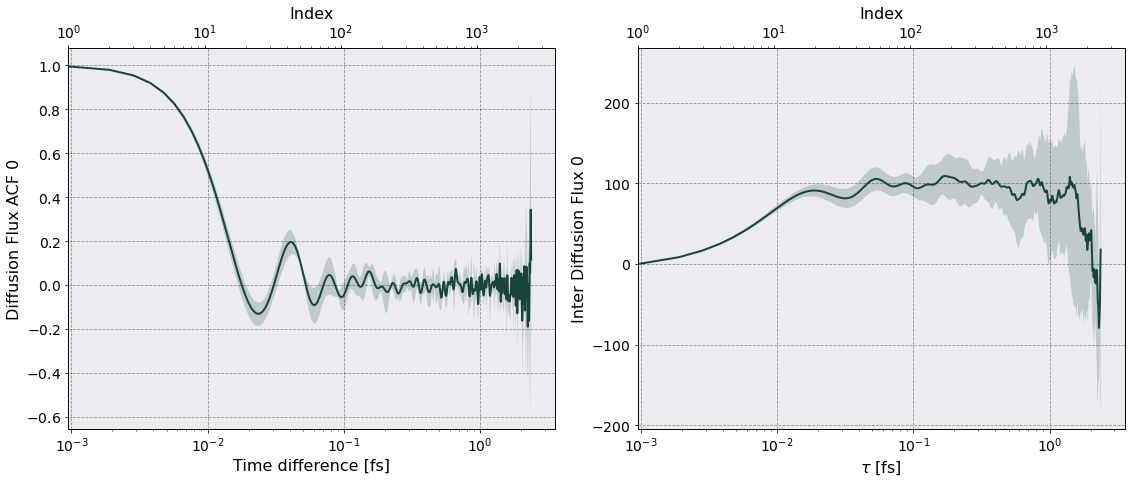

In [16]:
tc = TransportCoefficients(
        postproc.parameters,
        no_slices = 4)
tc.interdiffusion(jc_acf, plot = True)
# Note the info printed to screen

In [17]:
# Let's look at what we have
tc.interdiffusion_df

Time Inter Diffusion Flux 0              
               NaN                   Mean           Std
0     0.000000e+00               0.000000  0.000000e+00
1     9.500000e-19               0.000000  0.000000e+00
2     1.900000e-18               0.000008  3.826732e-07
3     2.850000e-18               0.000017  7.656943e-07
4     3.800000e-18               0.000025  1.148443e-06
...            ...                    ...           ...
2495  2.370250e-15               0.000012  1.937744e-04
2496  2.371200e-15               0.000014  1.957540e-04
2497  2.372150e-15               0.000016  1.975726e-04
2498  2.373100e-15               0.000017  1.992226e-04
2499  2.374050e-15               0.000018  2.006965e-04

[2500 rows x 3 columns]

As mentioned the InterDiffusion is calculated for each slice and then averaged. The left plot above shows the mean over the four slices of the Diffusion Flux ACF with its standard deviation as the shaded area. The upper x-axis (Index) indicates the index value in the dataframe.

Let's now plot this and compare with Hansen *et al.* result.

[None,
 Text(0.5, 0, 'Time [fs]'),
 Text(0.5, 1.0, 'H-He Interdiffusion $\\Gamma = 40$')]

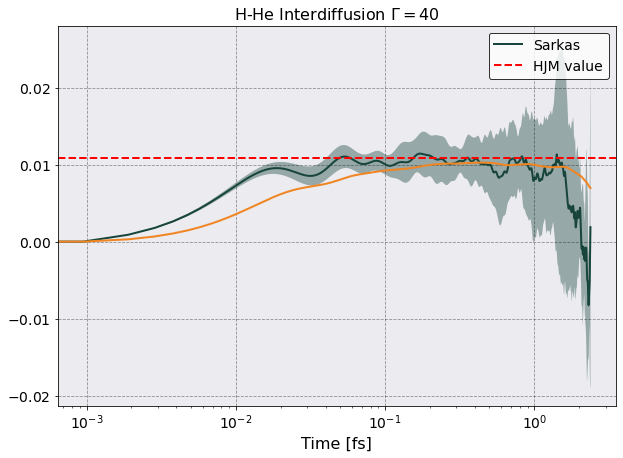

In [18]:
aws = postproc.parameters.a_ws
vaa = postproc.parameters.hydrodynamic_frequency
norm = 1/(vaa * aws**2 )

fig, ax = plt.subplots(1,1)
ax.plot(
    tc.interdiffusion_df["Time"]*1e15,
    tc.interdiffusion_df[("Inter Diffusion Flux 0","Mean")] * norm , 
    label = 'Sarkas')
ax.plot(
    tc.interdiffusion_df["Time"]*1e15, 
    norm * tc.interdiffusion_df[("Inter Diffusion Flux 0","Mean")].expanding().mean())

ax.fill_between( 
    tc.interdiffusion_df["Time"].iloc[:,0]*1e15, # I don't understand why I need iloc here but not above
    (tc.interdiffusion_df[("Inter Diffusion Flux 0","Mean")] - tc.interdiffusion_df[("Inter Diffusion Flux 0","Std")])*norm,
    (tc.interdiffusion_df[("Inter Diffusion Flux 0","Mean")] + tc.interdiffusion_df[("Inter Diffusion Flux 0","Std")])*norm,
    alpha = 0.4)

ax.axhline(0.0109, color = 'r', ls = '--', label='HJM value')
ax.legend()
ax.set(xscale = 'log', xlabel = 'Time [fs]', title = r'H-He Interdiffusion $\Gamma = 40$')


Looks good to me! 